In [1]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from persiantools.jdatetime import JalaliDate

In [2]:
BOURS_API = "https://cdn.tsetmc.com/api/MarketData/GetMarketValueByFlow/1/9999"
FARABOURS_API = "https://cdn.tsetmc.com/api/MarketData/GetMarketValueByFlow/2/9999"

In [3]:
def make_df(api_url):
    json_data = requests.get(api_url).json()
    dates = [item["deven"] for item in json_data["marketValue"]]
    market_values = [item["marketCap"] for item in json_data["marketValue"]]

    df = pd.DataFrame({
    "date": pd.to_datetime(dates, format="%Y%m%d"),
    "market_value": market_values,
    }).sort_values("date").reset_index(drop=True)
    
    df["date"] = df["date"].apply(
        lambda x: JalaliDate.to_jalali(x).strftime("%Y-%m-%d"))
    
    return df

def sma_and_bullish_cross(api_url):
    df = make_df(api_url)
    
    df["mv20"] = df["market_value"].rolling(20).mean()    # 20-day moving average
    df["mv60"] = df["market_value"].rolling(60).mean()    # 60-day moving average
    df["mv240"] = df["market_value"].rolling(240).mean()  # 240-day moving average
    
    df = df.dropna()
    df["bullish_cross"] = (
    (df["mv20"] > df["mv60"]) &
    (df["mv20"].shift(1) <= df["mv60"].shift(1)))
    
    return df

def plotting(api_url):
    df = sma_and_bullish_cross(api_url)
    
    plt.figure(figsize=(30, 15))

    sns.lineplot(data=df, x="date", y="market_value",
                label="Market Value", color="gray", linewidth=4)
    sns.lineplot(data=df, x="date", y="mv20",
                label="20-day MA", color="darkred", linewidth=3)
    sns.lineplot(data=df, x="date", y="mv60",
                label="60-day MA", color="blue", linewidth=3)
    sns.lineplot(data=df, x="date", y="mv240",
                label="240-day MA", color="green", linewidth=3.5)

    # annotate bullish crosses
    for _, row in df[df["bullish_cross"]].iterrows():
        if row["mv20"] < row["mv240"]:
            plt.annotate(
                "↑",
                xy=(row["date"], row["mv20"]),
                xytext=(row["date"], row["mv20"] * 0.88),
                textcoords="data",
                fontsize=80, color="black", ha="center"
            )

    # Chart appearance settings (dedented!)
    step = 90
    plt.xticks(df.index[::step], df["date"].iloc[::step], rotation=90, fontsize=25)
    plt.yticks(fontsize=25)

    plt.title("Market Value and Moving Averages", fontsize=28, weight="bold")
    plt.xlabel("Date (Jalali)", fontsize=22)
    plt.ylabel("Market Value", fontsize=22)
    plt.legend(loc="upper left", fontsize=26)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

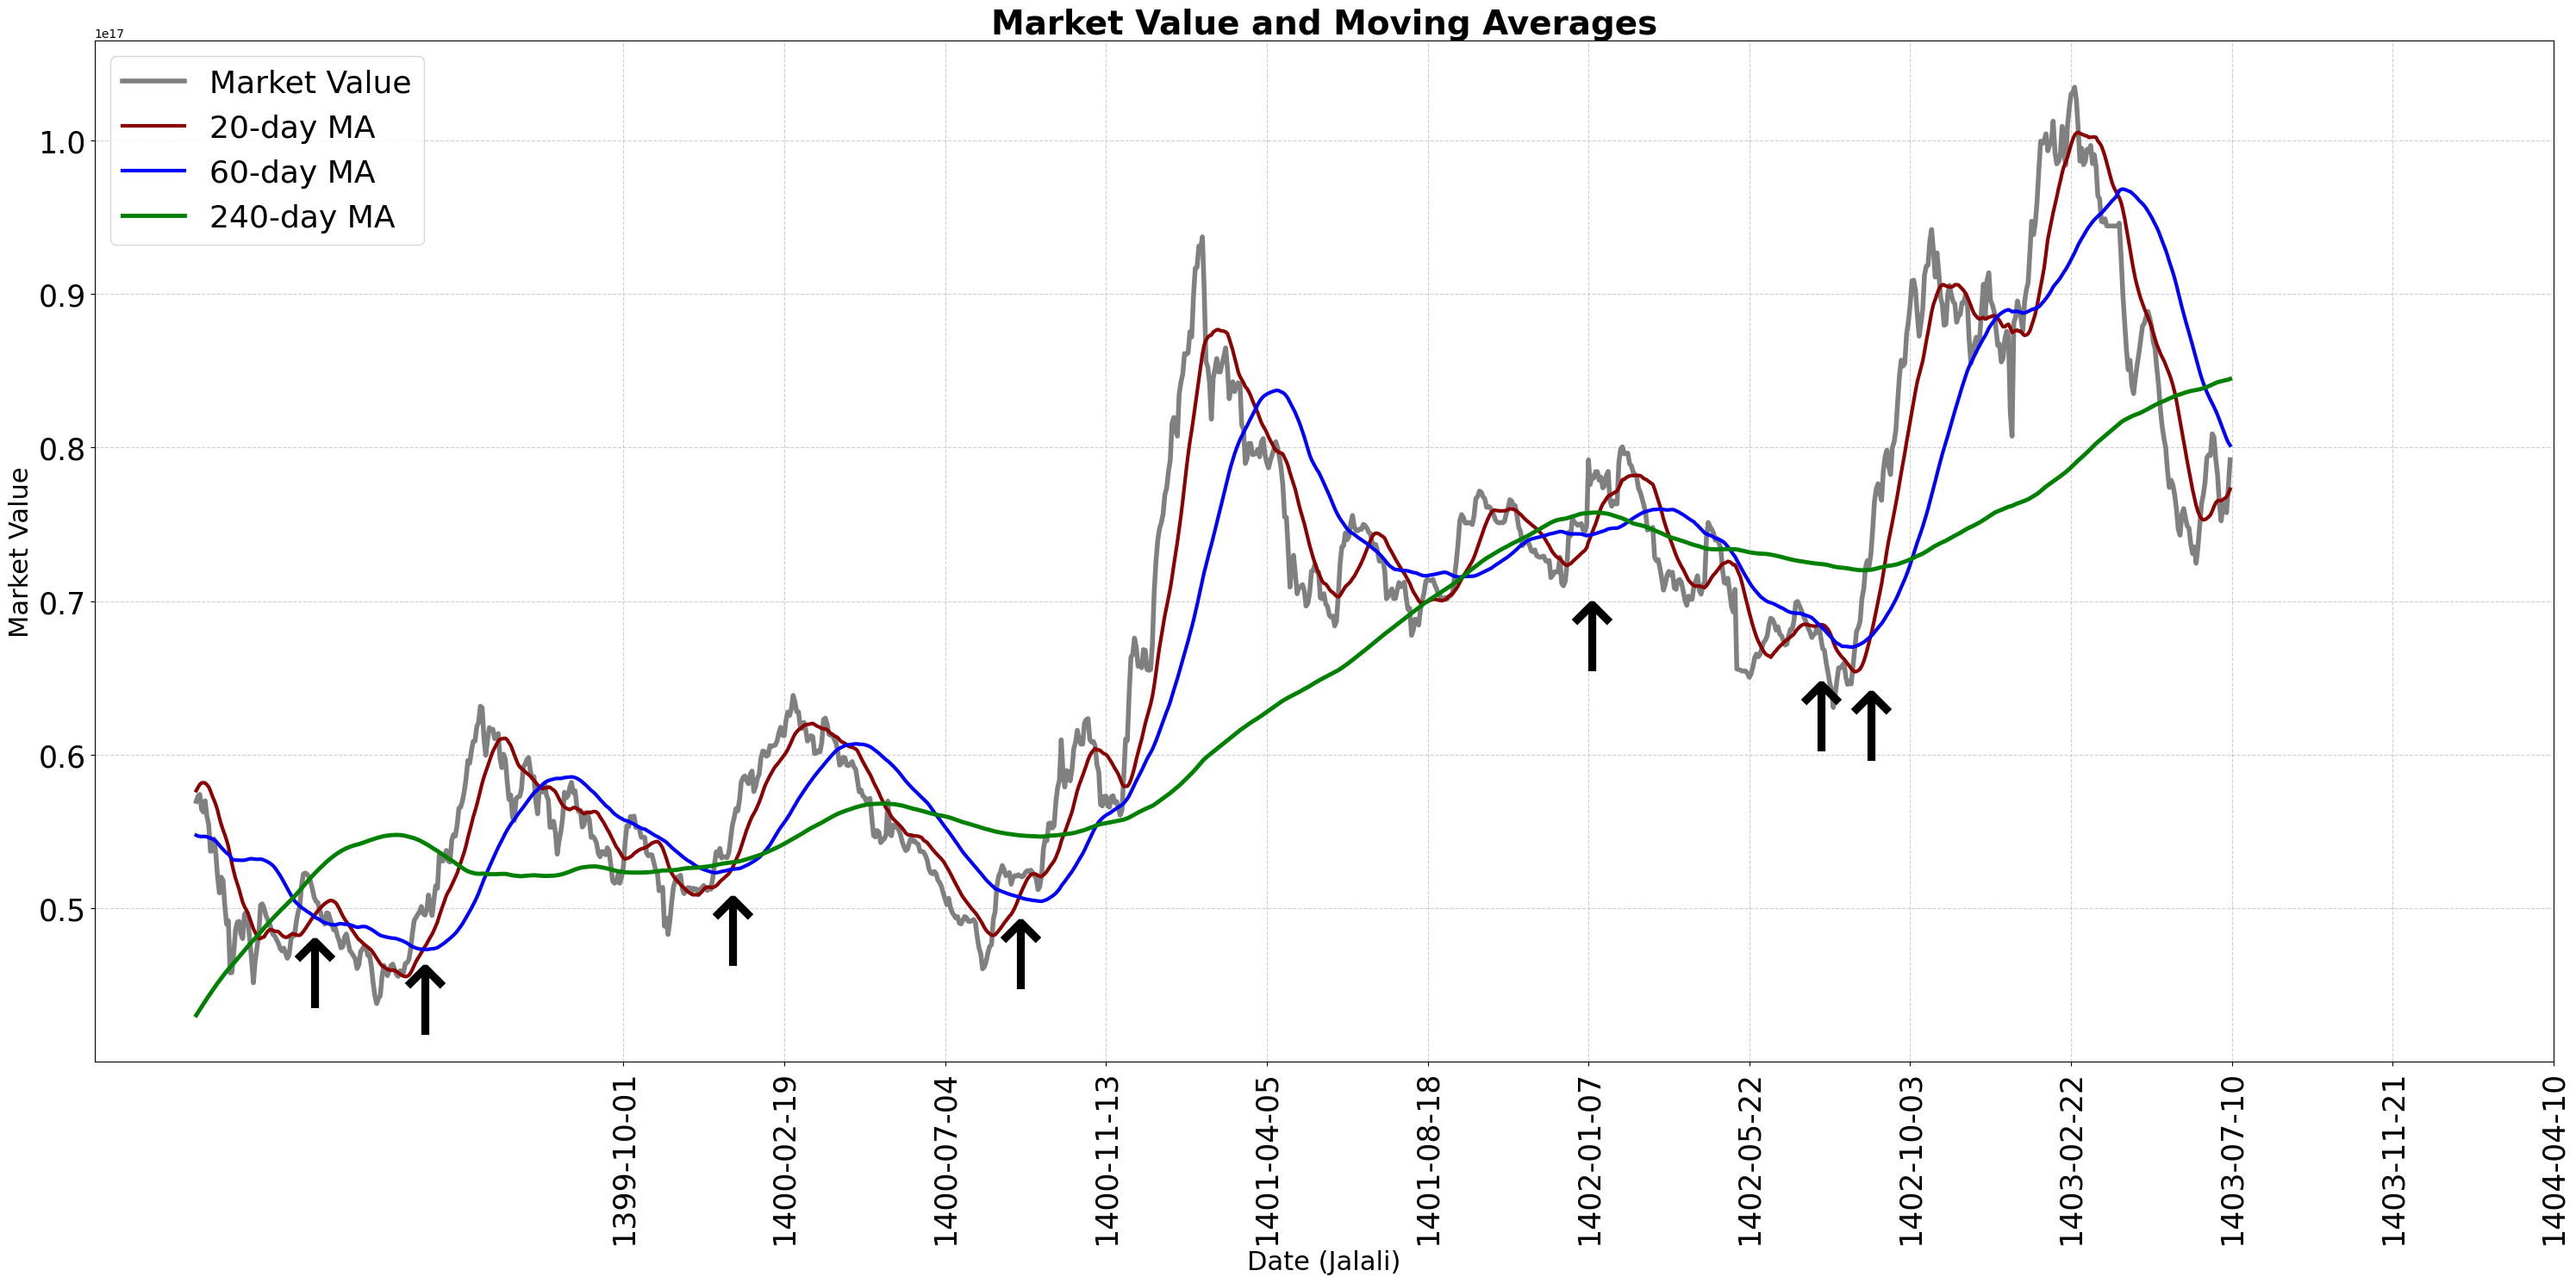

In [4]:
plotting(BOURS_API)

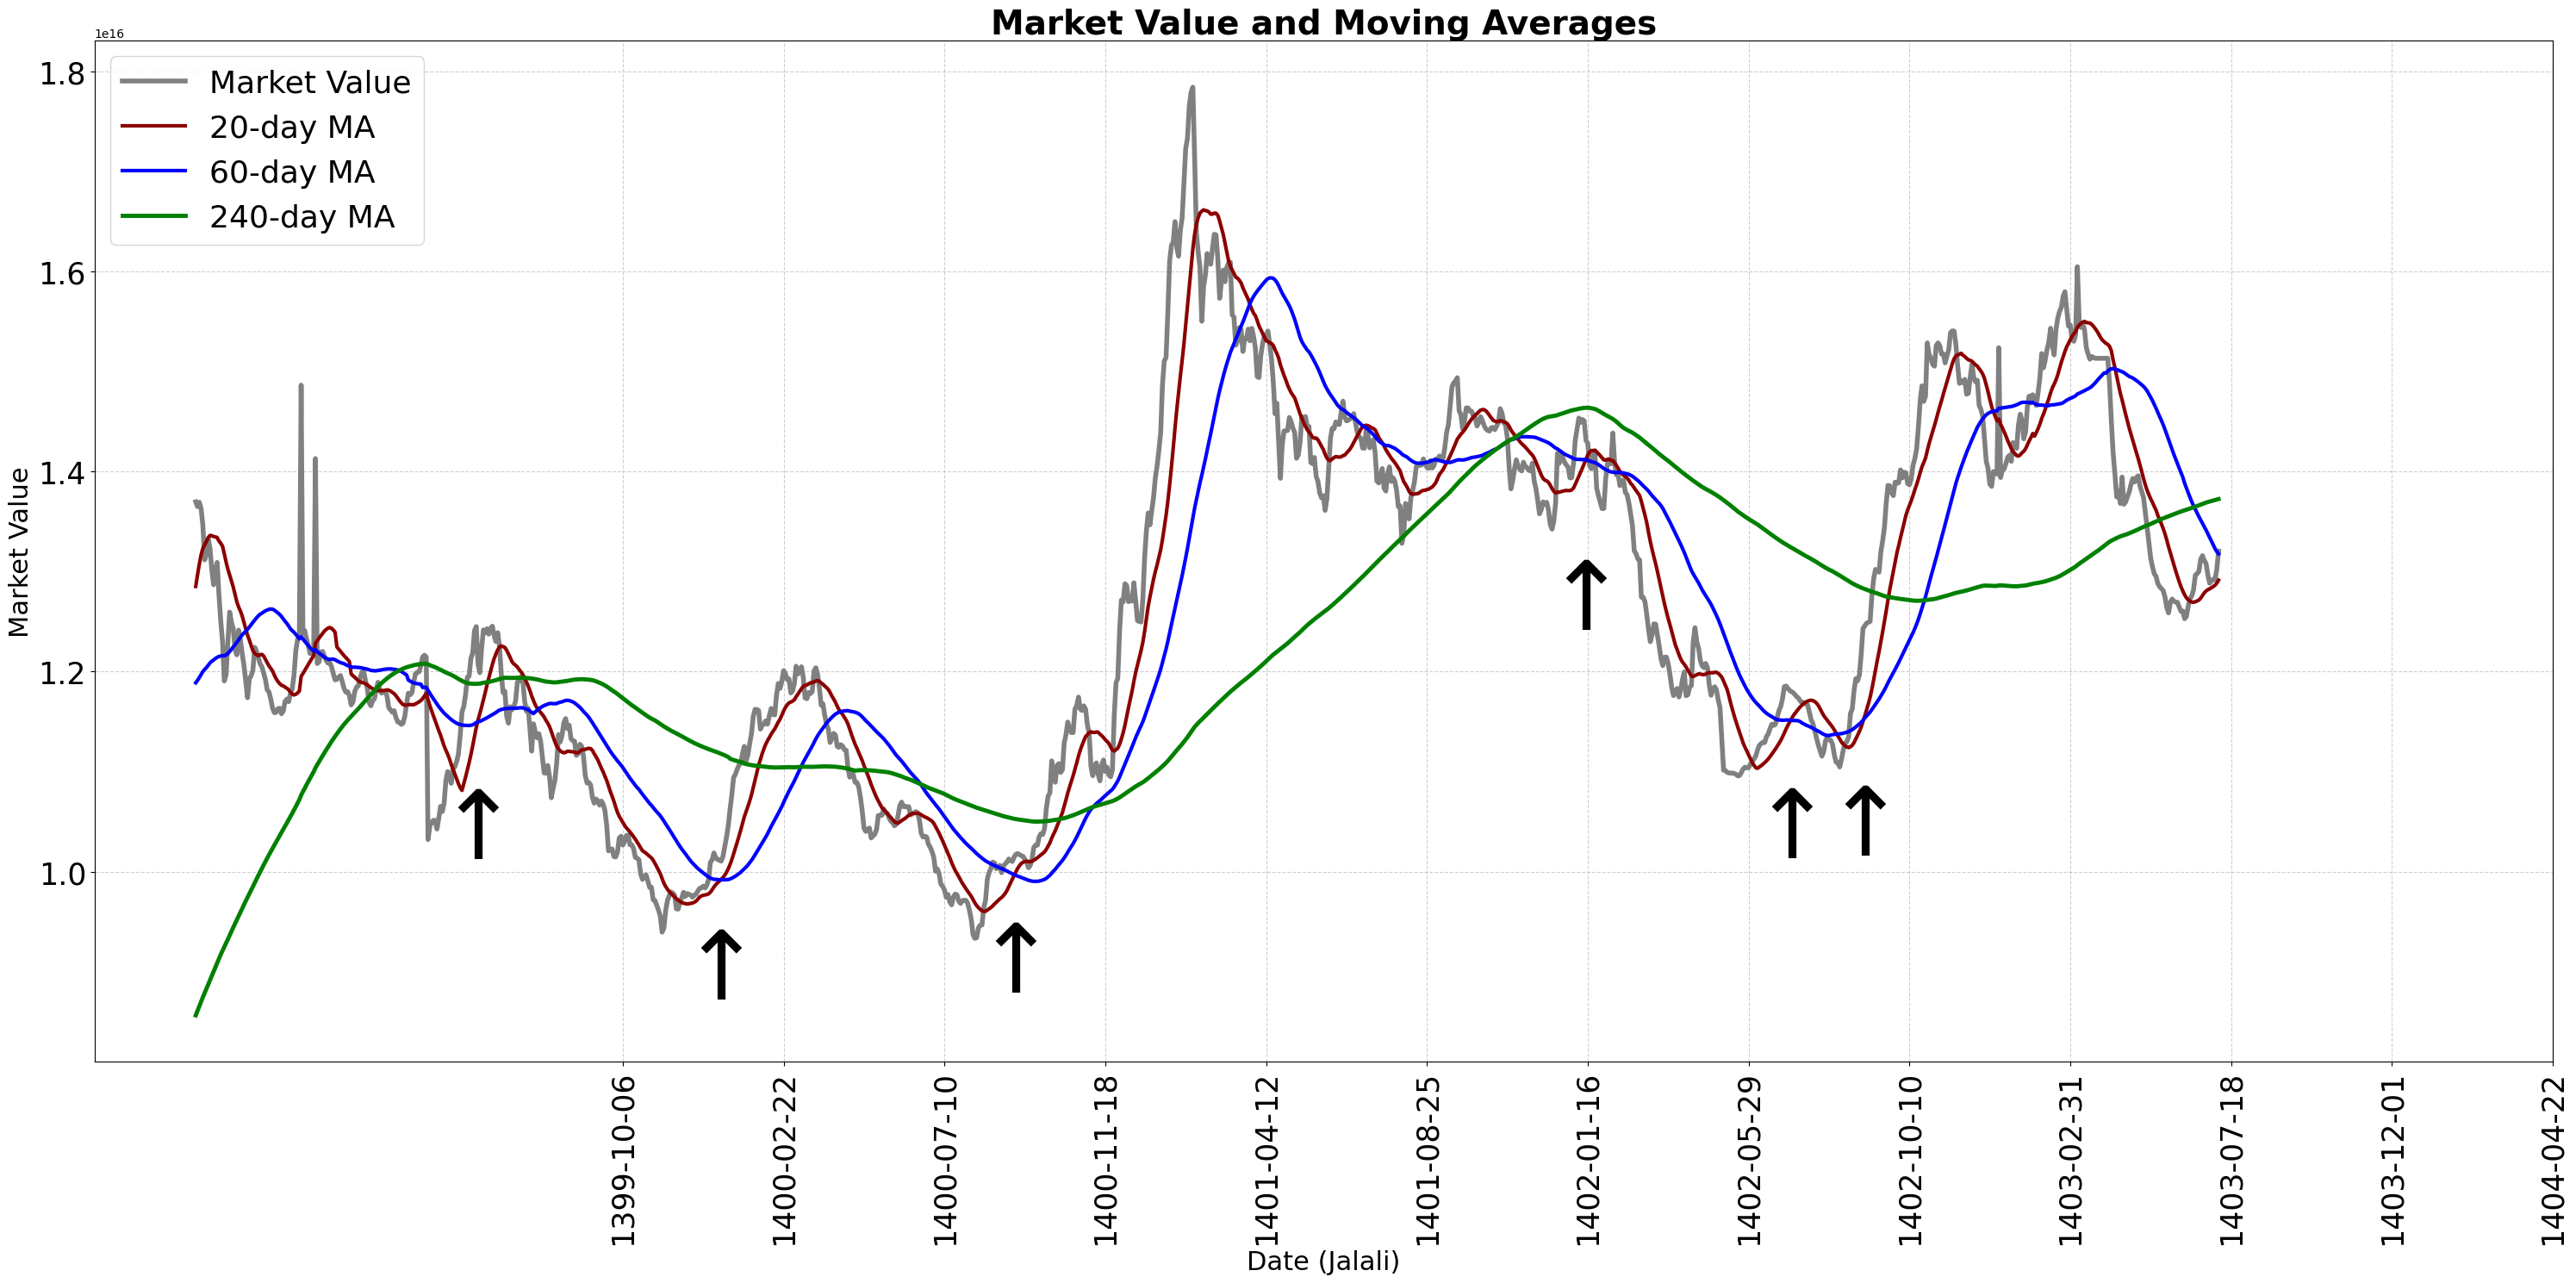

In [5]:
plotting(FARABOURS_API)